In [1]:
%config autocompleter.use_jedi=False
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
from fastai.vision import *
import torch
from data import *
from utils import *
from ranger import Ranger, RangerVA, RangerQH
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg16_bn

# Seed everything
seed_value = 42
import random 
random.seed(seed_value) # Python
import numpy as np
np.random.seed(seed_value) # cpu vars
import torch
torch.manual_seed(seed_value) # cpu  vars

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # gpu vars
    torch.backends.cudnn.deterministic = True  #needed
    torch.backends.cudnn.benchmark = False

from mish.mxresnet import mxresnet34, mxresnet50

DATA = Path('../Data/')
PATH_TRAIN = DATA/'Train_RealWorld'
PATH_VALID = DATA/'Validation_RealWorld'

Mish activation loaded...
Mish activation loaded...


In [3]:
tfms = get_transforms(max_warp=0.0)
seed = 42
data = get_data_new(1, size="full", dataset="new", tfms=tfms, seed=seed,
                   folders=[PATH_TRAIN.name, PATH_VALID.name], stats=real_stats)

PATH_TRAIN.name

a = PATH_VALID.ls()[0]; a
'_'.join(a.stem.split('_')[:-1]) + '.tif'

data.show_batch()

gram_matrix(t)

t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [4]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

base_loss = F.l1_loss

vgg_m = vgg16_bn(True).features

conv1 = getattr(vgg_m, '0')
conv_new = nn.Conv2d(31, 64, kernel_size=3, stride=1, padding=1)
weight_old = conv1.weight
weight_new = conv_new.weight

for i in range(10):
    weight_new[:, i:i+3] = weight_old.data.clone()
weight_new[:, 30] = weight_old.data[:, 0].clone()

conv_new.weight = nn.Parameter(weight_new)
setattr(vgg_m, '0', conv_new)

vgg_m = vgg_m.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

class FeatureLoss2(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts,mrse=True):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]
        self.mrae = MRAELoss()
        self.mrse = MRSELoss()
        self.mse = MSELossFlat()
        self.mrse_switch = mrse
        
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        if self.mrse_switch:
#             self.feat_losses = [self.mrae(input,target)]
            self.feat_losses = [100*self.mse(input,target)]
        else:
            self.feat_losses = [self.mrse(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [5]:
def xresnet34(*args, **kwargs):
    return models.xresnet34()

def xresnet50(*args, **kwargs):
    return models.xresnet50()

In [9]:
MSELossFlat

<function fastai.layers.MSELossFlat(*args, axis: int = -1, floatify: bool = True, **kwargs)>

In [6]:
feat_loss = FeatureLoss2(vgg_m, blocks[2:5], [3,9,2])

wd = 1e-3
# optimizer = RangerVA
# arch = models.resnet34
# arch = lambda x: models.xresnet34()
arch = lambda x: mxresnet50()
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, self_attention=True,
                     callback_fns = [partial(SaveModelCallback, every='improvement', monitor='MRAE', mode='min', name='MXR_best'),
                                     partial(CSVLogger, filename='25-3-20-NoGAN-MXR50-Real-1', append=True),
                                     ShowGraph],
                     blur=True, norm_type=NormType.Weight, metrics=MRAE)#.mixup(stack_y=False)
learn.load('25-3-20-NoGAN-MXR50-Real-1')
learn.unfreeze()
gc.collect();
lr = 1e-3

In [8]:
learn.validate()

[0.33592087, tensor(0.0846)]

In [8]:
import scipy.io
import torch
import cv2
import h5py
import hdf5storage

from NTIRE2020_spectral.SpectralUtils import savePNG, projectToRGB
filters_clean = np.load("NTIRE2020_spectral/resources/cie_1964_w_gain.npz")['filters']
filters_real = np.load("NTIRE2020_spectral/resources/example_D40_camera_w_gain.npz")['filters']

PATH = Path.cwd().parent/'Data'
PATH = PATH/'Test_RealWorld'

IMAGES = PATH.ls()

SUBMIT = Path('/home/ubuntu/competitions/hsi_reconstruction/Data/Submissions')
SUBMIT.mkdir(exist_ok=True)

save_dir = SUBMIT/'Test_Real'
save_dir.mkdir(exist_ok=True)


def stats(x):
    print("Shape:", x.shape)
    print("Min:",x.min())
    print("Max:",x.max())
    print("Mean:",x.mean())
    print("Std:",x.std())

def process_pred(x):
    x.clamp_(0, 1)
    x  = x.permute(1, 2, 0).numpy()
    return x

def get_submit_name(save_dir, im_path):
    im_path = Path(im_path)
    save_dir = Path(save_dir)
    name = '_'.join(im_path.name.split('_')[:-1])+'.mat'
    return save_dir/name

def save_pred(im_array, im_path, save_dir):
    im_path, save_dir = Path(im_path), Path(save_dir)
    fname = get_submit_name(save_dir, im_path)
    matdata = {u'cube':im_array}
    save_dir.mkdir(exist_ok=True)
    hdf5storage.write(matdata, '.', fname, matlab_compatible=True)
    
def save_preds(learn=learn, IMAGES=IMAGES, save_dir=save_dir):
    from tqdm.notebook import tqdm as tqdm
    for im_path in tqdm(IMAGES):
        image = open_image(im_path)
        pred = learn.predict(image)[1]
        pred = process_pred(pred)
        mxr_real = np.true_divide(projectToRGB(pred, filters_real), 256)/255
        plt.imshow(mxr_real)
        plt.show()
        save_pred(pred, im_path, save_dir)

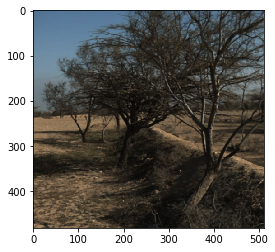

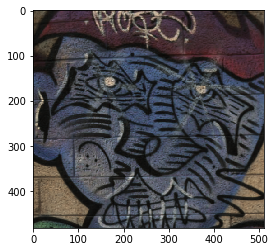

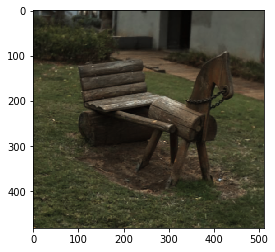

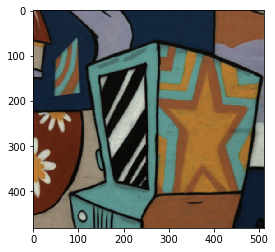

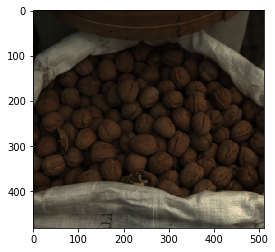

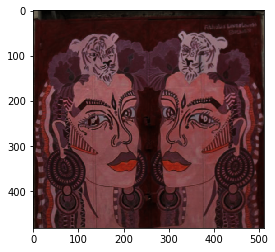

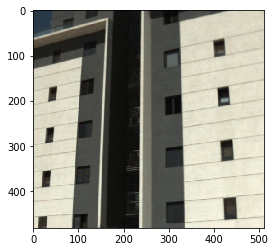

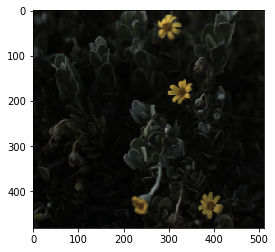

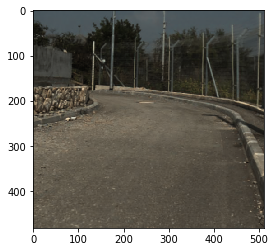

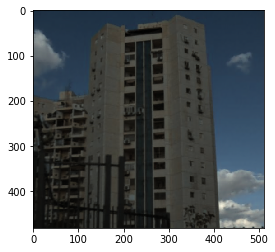

In [9]:
save_preds(save_dir=save_dir)

In [7]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.3, epochs=None):
    learn.fit_one_cycle(ifnone(epochs,10), lrs, pct_start=pct_start, div_factor=100)
#     learn.fit_fc(ifnone(epochs,10), lrs, start_pct=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

Better model found at epoch 0 with MRAE value: 0.4754341244697571.


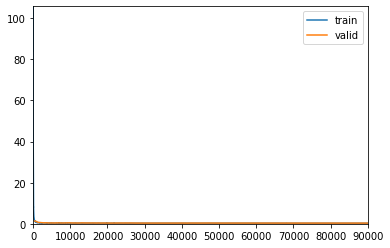

Better model found at epoch 1 with MRAE value: 0.3435325026512146.
Better model found at epoch 2 with MRAE value: 0.25255635380744934.
Better model found at epoch 4 with MRAE value: 0.20537924766540527.
Better model found at epoch 5 with MRAE value: 0.16335535049438477.
Better model found at epoch 6 with MRAE value: 0.15396612882614136.
Better model found at epoch 9 with MRAE value: 0.1509646475315094.
Better model found at epoch 10 with MRAE value: 0.13543029129505157.
Better model found at epoch 12 with MRAE value: 0.12041816860437393.
Better model found at epoch 25 with MRAE value: 0.11328025907278061.
Better model found at epoch 26 with MRAE value: 0.10938433557748795.
Better model found at epoch 27 with MRAE value: 0.10890891402959824.
Better model found at epoch 33 with MRAE value: 0.10805878788232803.
Better model found at epoch 35 with MRAE value: 0.0984804704785347.
Better model found at epoch 43 with MRAE value: 0.09682165086269379.
Better model found at epoch 60 with MRAE va

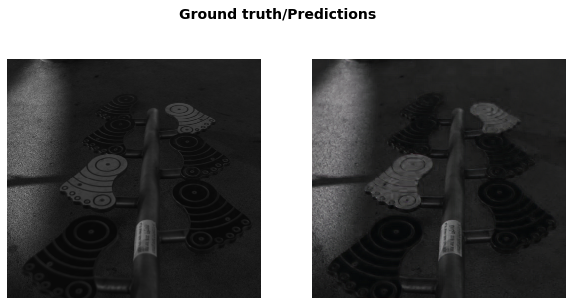

In [9]:
learn.to_fp16()
do_fit('25-3-20-NoGAN-MXR50-Real-1', 1e-3, epochs=200)

Better model found at epoch 0 with MRAE value: 0.33475354313850403.


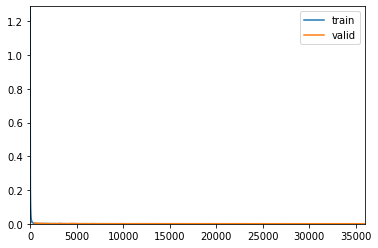

Better model found at epoch 1 with MRAE value: 0.2719966173171997.
Better model found at epoch 2 with MRAE value: 0.18285027146339417.
Better model found at epoch 3 with MRAE value: 0.159250408411026.
Better model found at epoch 5 with MRAE value: 0.1444290727376938.
Better model found at epoch 7 with MRAE value: 0.12115252017974854.
Better model found at epoch 11 with MRAE value: 0.10929367691278458.
Better model found at epoch 13 with MRAE value: 0.10196063667535782.
Better model found at epoch 19 with MRAE value: 0.09316158294677734.
Better model found at epoch 31 with MRAE value: 0.09093039482831955.
Better model found at epoch 32 with MRAE value: 0.09057645499706268.
Better model found at epoch 43 with MRAE value: 0.08710258454084396.
Better model found at epoch 45 with MRAE value: 0.08623506128787994.
Better model found at epoch 46 with MRAE value: 0.08482490479946136.
Better model found at epoch 52 with MRAE value: 0.08351035416126251.
Better model found at epoch 63 with MRAE va

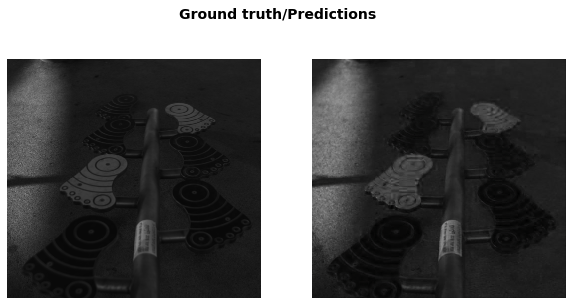

In [8]:
learn.to_fp16()
do_fit('24-3-20-NoGAN-MXR50-Real-1', 3e-3, epochs=80)

Better model found at epoch 0 with MRAE value: 1.0676020383834839.


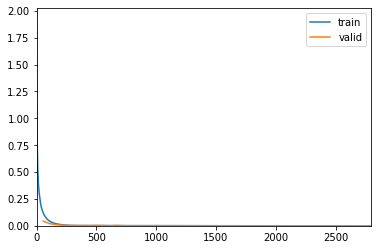

Better model found at epoch 1 with MRAE value: 0.6688406467437744.
Better model found at epoch 2 with MRAE value: 0.5114675760269165.
Better model found at epoch 3 with MRAE value: 0.35706356167793274.
Better model found at epoch 4 with MRAE value: 0.2513684034347534.
Better model found at epoch 5 with MRAE value: 0.23829486966133118.
Better model found at epoch 7 with MRAE value: 0.2179766446352005.
Better model found at epoch 10 with MRAE value: 0.15865178406238556.
Better model found at epoch 12 with MRAE value: 0.15020820498466492.
Better model found at epoch 14 with MRAE value: 0.1278800070285797.
Better model found at epoch 16 with MRAE value: 0.12197120487689972.
Better model found at epoch 21 with MRAE value: 0.11425763368606567.
Better model found at epoch 23 with MRAE value: 0.10844780504703522.
Better model found at epoch 24 with MRAE value: 0.10703875869512558.
Better model found at epoch 27 with MRAE value: 0.10274790227413177.
Better model found at epoch 28 with MRAE valu

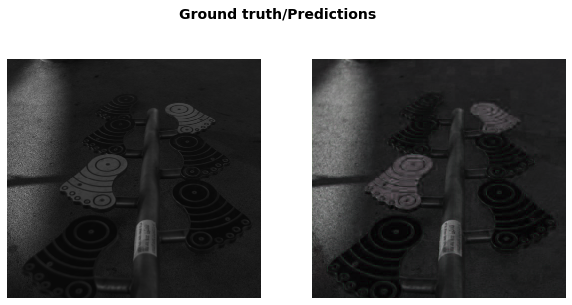

In [8]:
learn.to_fp16()
do_fit('24-3-20-NoGAN-MXR34-Real-1', 3e-3, epochs=50)

In [11]:
learn.callback_fns.pop(-1)

fastai.callbacks.loss_metrics.LossMetrics

Better model found at epoch 0 with MRAE value: 0.08563626557588577.


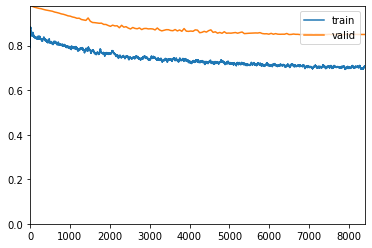

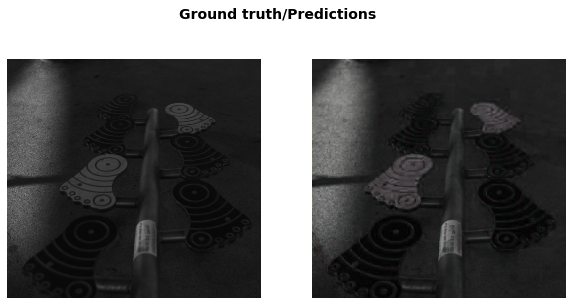

In [12]:
learn.loss_func = feat_loss
learn.callback_fns.append(LossMetrics)
learn.unfreeze()
learn.to_fp16()
do_fit('24-3-20-NoGAN-MXR34-Real-2', slice(5e-5,2e-4), epochs=150)

Better model found at epoch 0 with MRAE value: 0.511721134185791.


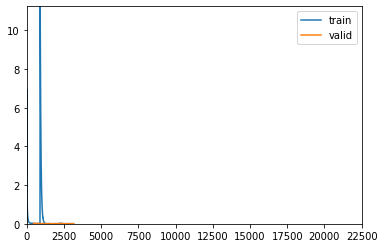

Better model found at epoch 1 with MRAE value: 0.3676344156265259.
Better model found at epoch 2 with MRAE value: 0.21647341549396515.
Better model found at epoch 3 with MRAE value: 0.19248291850090027.
Better model found at epoch 5 with MRAE value: 0.17155975103378296.


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f1bd06d5290> (for post_execute):


KeyboardInterrupt: 

In [8]:
learn.to_fp16()
do_fit('24-3-20-NoGAN-MXR-Real-3', 1e-3, epochs=50)

Better model found at epoch 0 with MRAE value: 0.24601221084594727.


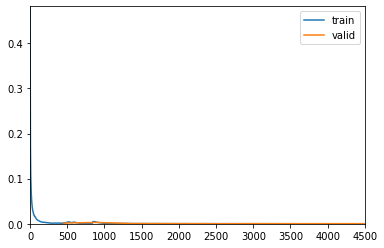

Better model found at epoch 1 with MRAE value: 0.24289974570274353.
Better model found at epoch 2 with MRAE value: 0.15758982300758362.
Better model found at epoch 3 with MRAE value: 0.13313497602939606.
Better model found at epoch 4 with MRAE value: 0.11201510578393936.
Better model found at epoch 5 with MRAE value: 0.10305682569742203.
Better model found at epoch 7 with MRAE value: 0.09283853322267532.


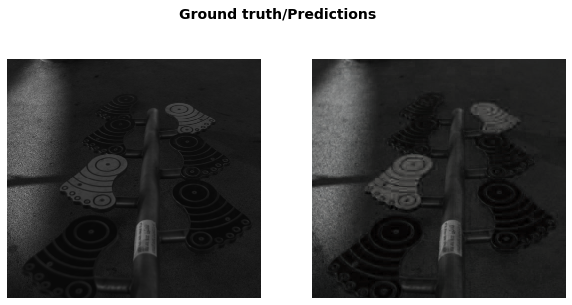

In [8]:
learn.to_fp16()
# learn.callback_fns.pop(0)
do_fit('24-3-20-NoGAN-MXR-Real-2', 3e-3)

Better model found at epoch 0 with MRAE value: 0.09294186532497406.


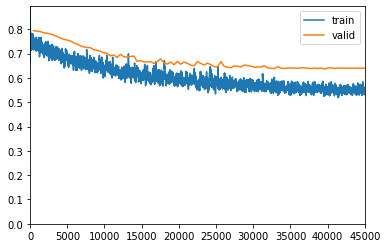

Better model found at epoch 44 with MRAE value: 0.09292352944612503.
Better model found at epoch 52 with MRAE value: 0.09196211397647858.
Better model found at epoch 54 with MRAE value: 0.09191962331533432.
Better model found at epoch 55 with MRAE value: 0.09149877727031708.
Better model found at epoch 67 with MRAE value: 0.09092868864536285.
Better model found at epoch 74 with MRAE value: 0.09058113396167755.
Better model found at epoch 75 with MRAE value: 0.0905744805932045.
Better model found at epoch 79 with MRAE value: 0.09052851796150208.
Better model found at epoch 87 with MRAE value: 0.09045840799808502.


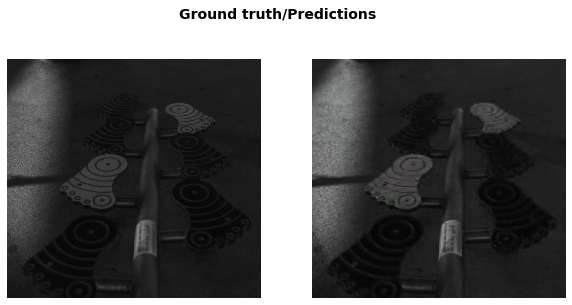

In [8]:
learn.loss_func = feat_loss
learn.callback_fns.append(LossMetrics)
learn.to_fp16()
do_fit('24-3-20-NoGAN-MXR-Real-3', slice(1e-5,2e-4), epochs=100)

Better model found at epoch 0 with MRAE value: 0.3155285716056824.


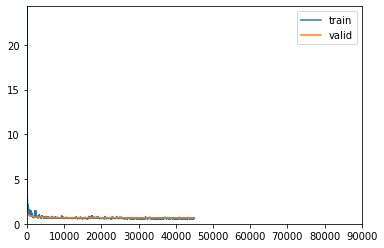

Better model found at epoch 1 with MRAE value: 0.20677125453948975.
Better model found at epoch 2 with MRAE value: 0.18607348203659058.
Better model found at epoch 3 with MRAE value: 0.136638805270195.
Better model found at epoch 5 with MRAE value: 0.12792280316352844.
Better model found at epoch 7 with MRAE value: 0.12750877439975739.
Better model found at epoch 9 with MRAE value: 0.1248084157705307.
Better model found at epoch 10 with MRAE value: 0.11823098361492157.
Better model found at epoch 12 with MRAE value: 0.10662449896335602.
Better model found at epoch 19 with MRAE value: 0.1048424020409584.
Better model found at epoch 21 with MRAE value: 0.09874159842729568.
Better model found at epoch 31 with MRAE value: 0.09808959811925888.
Better model found at epoch 32 with MRAE value: 0.09508863091468811.
Better model found at epoch 44 with MRAE value: 0.09311278164386749.
Better model found at epoch 52 with MRAE value: 0.09162349998950958.
Better model found at epoch 61 with MRAE val

In [ ]:
learn.to_fp16()
do_fit('24-3-20-NoGAN-MXR-Real-1', 1e-3, epochs=200)

Better model found at epoch 0 with MRAE value: 0.27951082587242126.


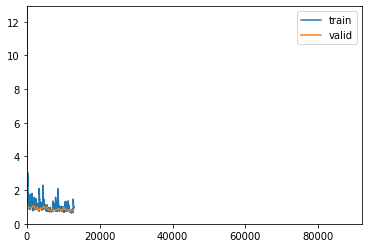

Better model found at epoch 1 with MRAE value: 0.25913625955581665.
Better model found at epoch 4 with MRAE value: 0.23498602211475372.
Better model found at epoch 6 with MRAE value: 0.14419841766357422.
Better model found at epoch 25 with MRAE value: 0.13122200965881348.


In [ ]:
learn.to_fp16()
do_fit('23-3-20-NoGAN-MXR-Real-1', 3e-3, epochs=200)

Better model found at epoch 0 with MRAE value: 0.8108468055725098.


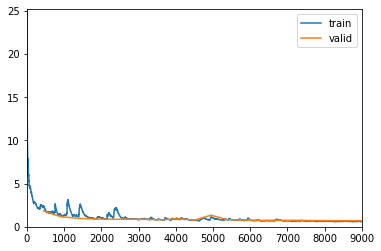

Better model found at epoch 1 with MRAE value: 0.36550217866897583.
Better model found at epoch 2 with MRAE value: 0.2807658314704895.
Better model found at epoch 3 with MRAE value: 0.20193496346473694.
Better model found at epoch 4 with MRAE value: 0.20189614593982697.
Better model found at epoch 7 with MRAE value: 0.17009082436561584.
Better model found at epoch 9 with MRAE value: 0.1465264856815338.
Better model found at epoch 13 with MRAE value: 0.12857268750667572.
Better model found at epoch 16 with MRAE value: 0.1189495176076889.
Better model found at epoch 17 with MRAE value: 0.11645002663135529.
Better model found at epoch 18 with MRAE value: 0.11404471099376678.
Better model found at epoch 19 with MRAE value: 0.11385194957256317.


RuntimeError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 15.75 GiB total capacity; 14.09 GiB already allocated; 64.88 MiB free; 622.90 MiB cached)

In [8]:
learn.to_fp16()
do_fit('23-3-20-NoGAN-MXR-Real-1', 1e-3, epochs=20)

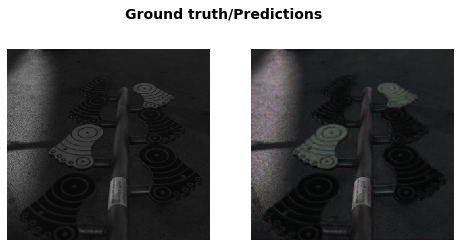

In [9]:
learn.show_results()

[941.66516, tensor(941.3504)]


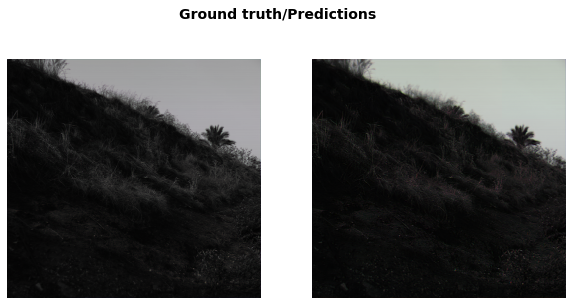

In [10]:
d = ImageHSImageList.from_folder(path='../Data/Pseudo_Clean',extensions='.png').filter_by_func(lambda p: "ARAD" in str(p)).split_none().label_from_func(lambda x: f"../Data/Pseudo_Spectral_Tensors/{x.stem[:-6] + '.tif'}").transform().databunch(bs=1).normalize(imagenet_stats)

learn.data.valid_dl = d.train_dl
print(learn.validate())
learn.show_results(imgsize=5)

[1005.5861, tensor(1005.2336)]


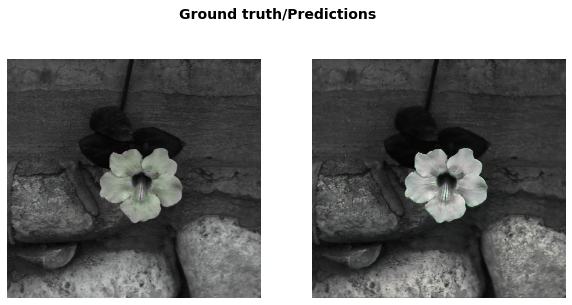

In [12]:
real_stats = (tensor([0.1859, 0.1794, 0.1533]), tensor([0.1244, 0.1235, 0.1181]))
d = ImageHSImageList.from_folder(path='../Data/Pseudo_Clean',extensions='.png').filter_by_func(lambda p: "ARAD" in str(p)).split_none().label_from_func(lambda x: f"../Data/Pseudo_Spectral_Tensors/{x.stem[:-6] + '.tif'}").transform().databunch(bs=1).normalize(real_stats)

learn.to_fp32()
learn.model.eval()
learn.data.valid_dl = d.train_dl

print(learn.validate())
learn.show_results(imgsize=5)

[0.40616027, tensor(1063.6609)]


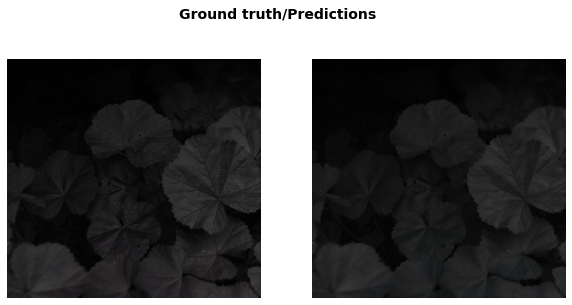

In [10]:
real_stats = (tensor([0.1859, 0.1794, 0.1533]), tensor([0.1244, 0.1235, 0.1181]))
d = ImageHSImageList.from_folder(path='../Data/Pseudo_Clean',extensions='.png').filter_by_func(lambda p: "ARAD" in str(p)).split_none().label_from_func(lambda x: f"../Data/Pseudo_Spectral_Tensors/{x.stem[:-6] + '.tif'}").transform().databunch(bs=1).normalize(real_stats)

learn.to_fp32()
learn.model.eval()
learn.data.valid_dl = d.train_dl

print(learn.validate())
learn.show_results(imgsize=5)

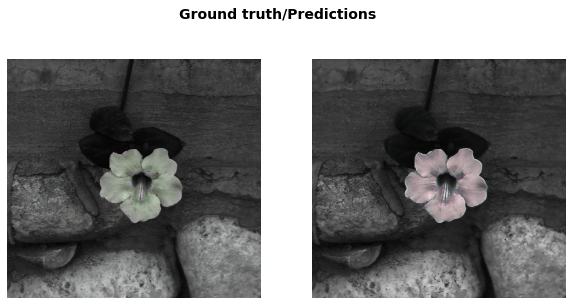

In [17]:
learn.show_results(imgsize=5)

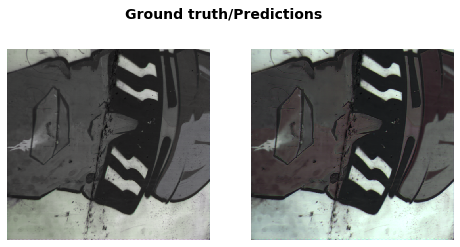

In [16]:
learn.show_results()

In [18]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

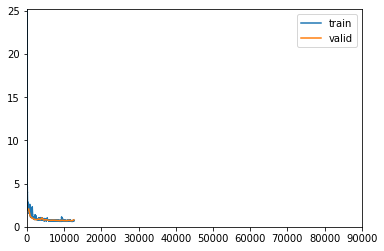

In [ ]:
learn.to_fp16()
do_fit('23-3-20-NoGAN-MXR-Real-1', 1e-3, epochs=200)

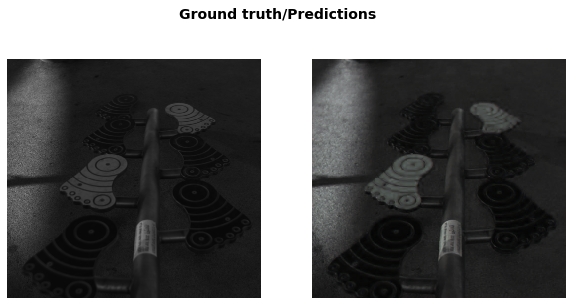

In [23]:
do_fit('20-3-20-NoGAN-MXR-Real-1', slice(lr), epochs=100)

In [46]:
learn.unfreeze()

In [ ]:
do_fit('20-3-20-NoGAN-Mixup-2', slice(2e-5,1e-3), pct_start=0.3, epochs=50)